# Simple visualisation of a CMIP6 dataset with Python Xarray

  - this is an adoption of [NordicESMhub example](https://nordicesmhub.github.io/NEGI-Abisko-2019/training/CMIP6_example.html) to use CMIP6 data stored in the DKRZ data pool 

In [1]:
filename = '/pool/data/CMIP6/data/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190308/tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc'

### Import python packages

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import cftime

## Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

In [3]:
dset = xr.open_dataset(filename, decode_times=True, use_cftime=True)
print(dset)

<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
    lat_bnds   (lat, nbnd) float32 ...
    lon_bnds   (lon, nbnd) float32 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                15
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-16T23:34:05Z
    ...                     ...
    sub_experiment:         none
    sub_experiment_id:      none
    branch_time_in_parent:  219000.0
    branch_time_in_child:   674885.0
    

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


### Get metadata corresponding to near-surface air temperature (tas)

In [4]:
print(dset['tas'])

<xarray.DataArray 'tas' (time: 1980, lat: 192, lon: 288)>
[109486080 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variabl

In [5]:
dset.time.values

array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

### Select time

- Select a specific time

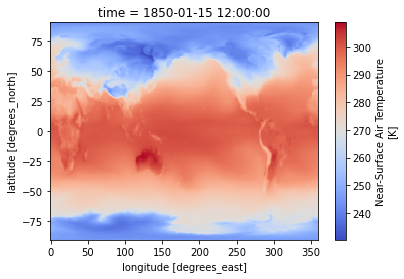

In [6]:
dset['tas'].sel(time=cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, 2, 15)).plot(cmap = 'coolwarm')

- select the nearest time. Here from 1st April 1950

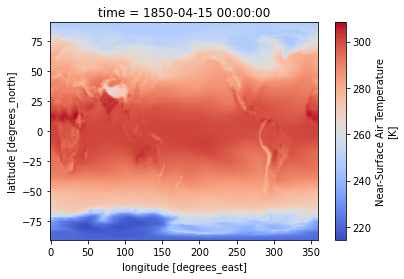

In [7]:
dset['tas'].sel(time=cftime.DatetimeNoLeap(1850, 4, 1), method='nearest').plot(cmap='coolwarm')

## Customize plot

### Set the size of the figure and add coastlines

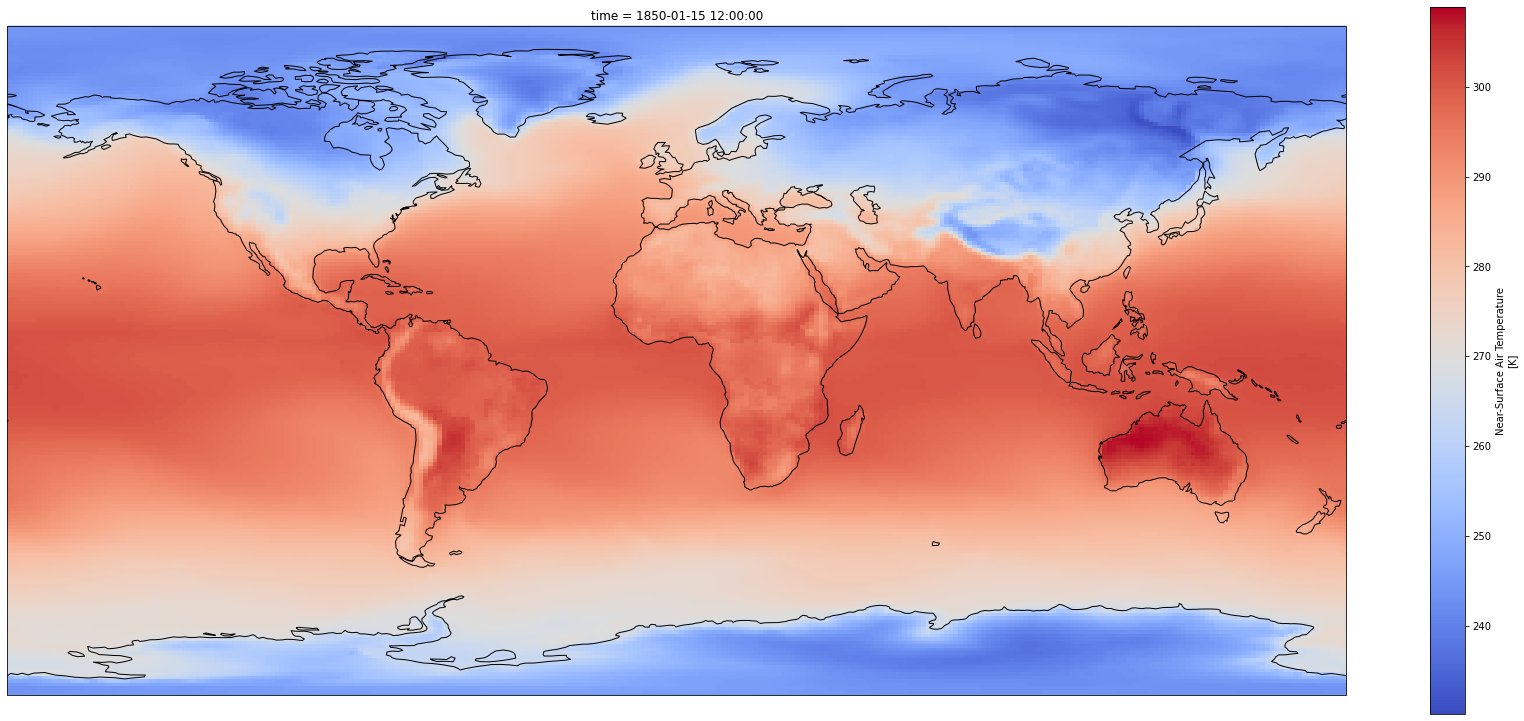

In [8]:
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
dset['tas'].isel(time=0).plot.pcolormesh(ax=ax, cmap='coolwarm')

### Change plotting projection

Text(0.5, 1.0, 'January 1850')

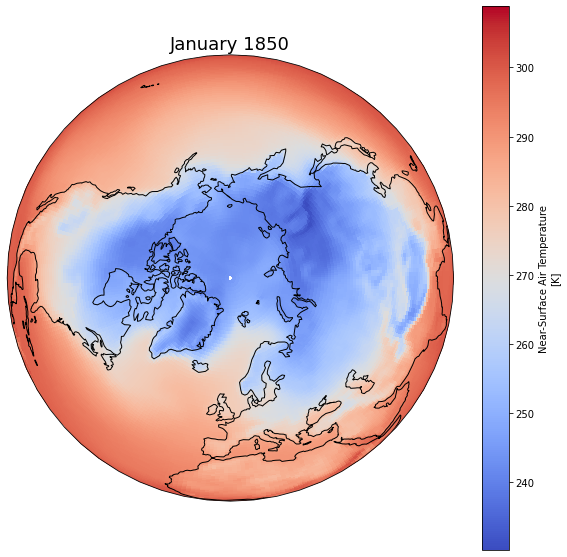

In [9]:
fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
dset['tas'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(dset.time.values[0].strftime("%B %Y"), fontsize=18)

### Choose the extent of values
- Fix your minimum and maximum values in your plot and
- Use extend so values below the minimum and max

Text(0.5, 1.0, 'January 1850')

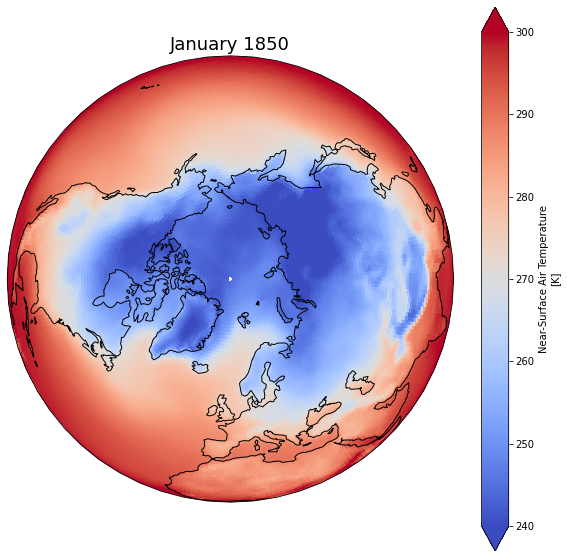

In [10]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = 240
maxval = 300

# pass extent with vmin and vmax parameters
dset['tas'].isel(time=0).plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(dset.time.values[0].strftime("%B %Y"), fontsize=18)

## Multiplots

### Faceting

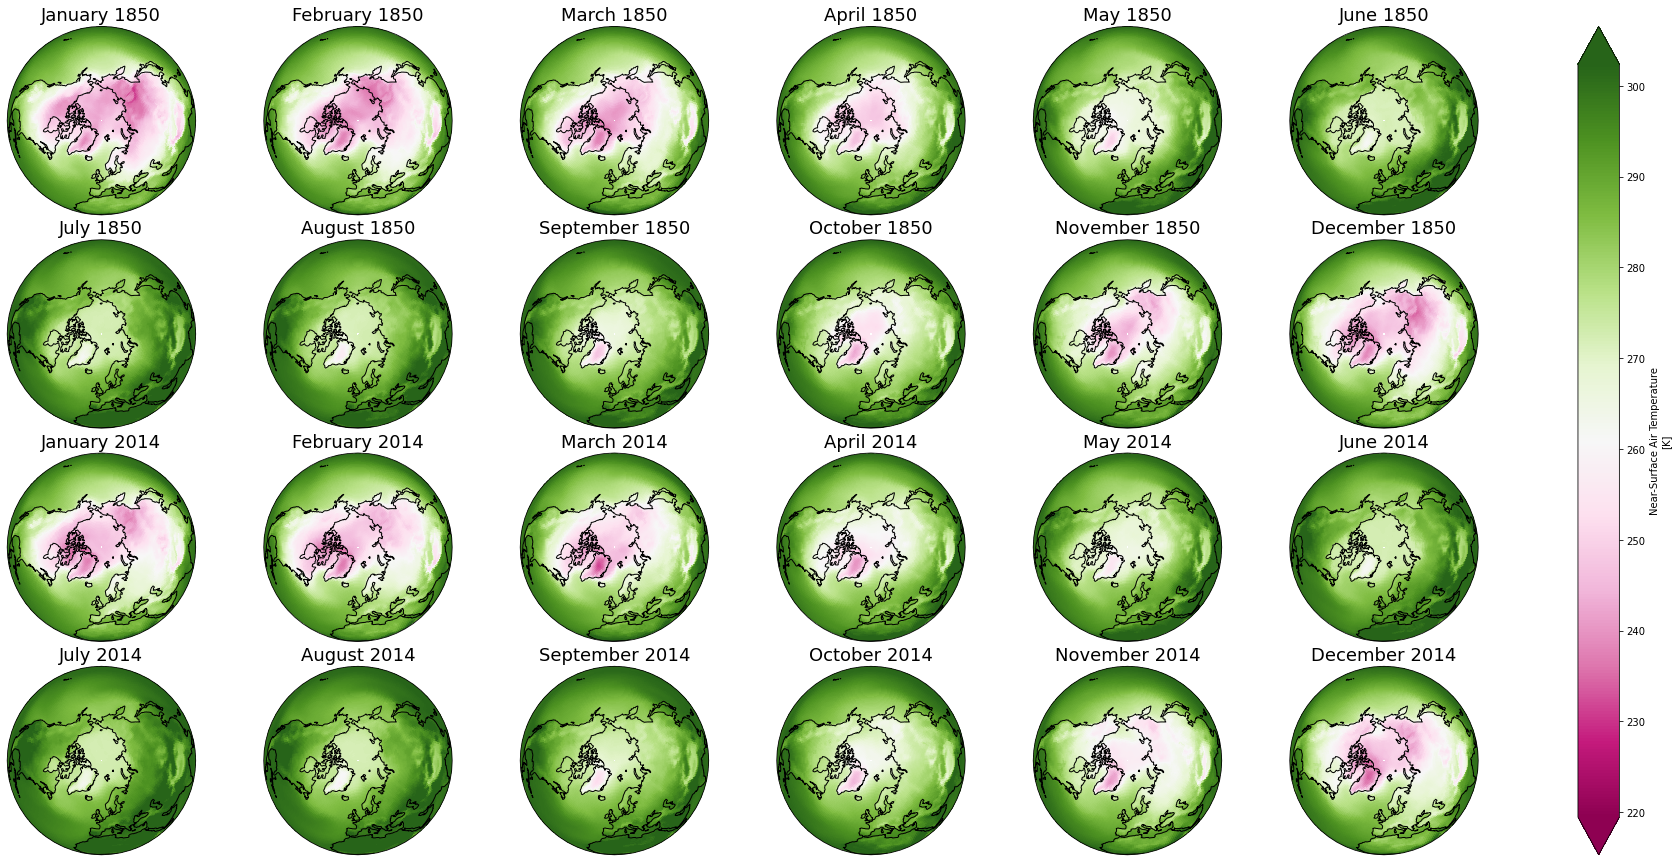

In [11]:
proj_plot = ccrs.Orthographic(0, 90)

p = dset['tas'].sel(time = dset.time.dt.year.isin([1850, 2014])).plot(x='lon', y='lat', 
                                                                 transform=ccrs.PlateCarree(),
                                                                 aspect=dset.dims["lon"] / dset.dims["lat"],  # for a sensible figsize
                                                                 subplot_kws={"projection": proj_plot},
                                                                 col='time', col_wrap=6, robust=True, cmap='PiYG')
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  dset.time.sel(time = dset.time.dt.year.isin([1850, 2014])).values):
    ax.coastlines()
    ax.set_title(i.strftime("%B %Y"), fontsize=18)

### Combine plots with different projections

Text(0, 0.5, 'K')

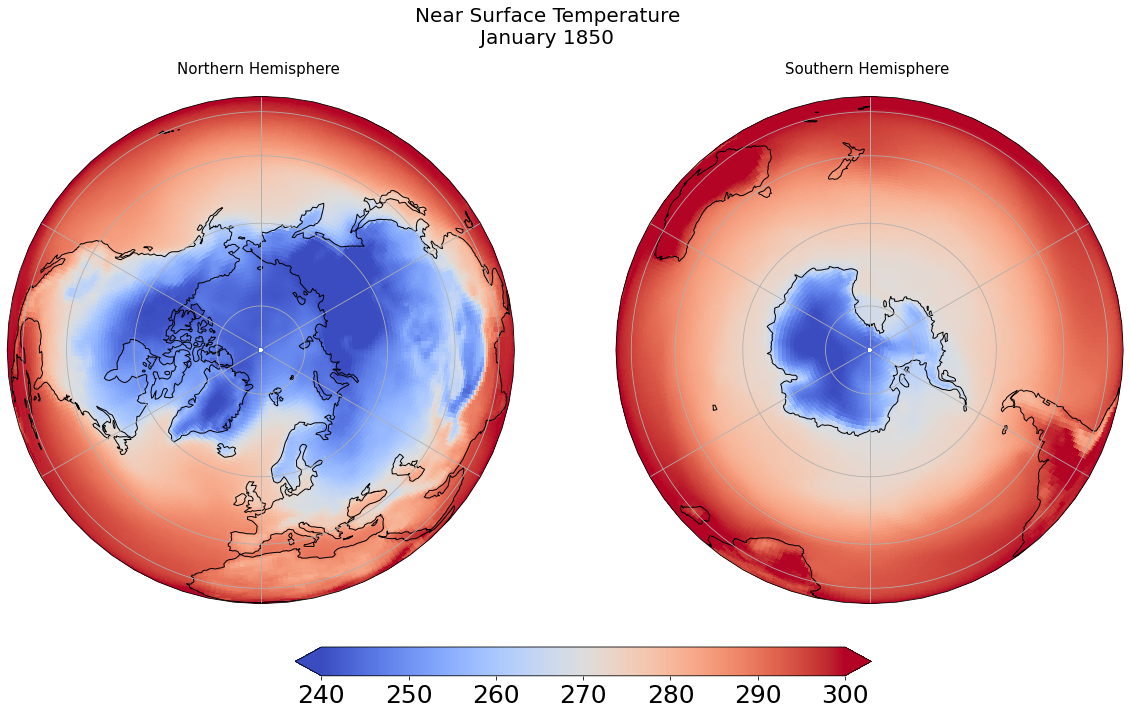

In [12]:
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = 240
maxval = 300

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 0
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = dset['tas'].isel(time=tsel).plot(ax=ax, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature\n' + dset.time.values[tsel].strftime("%B %Y"), fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)